In [44]:
############################################第四天 重复网络的构建############################################
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#导入influence数据集
df_infl = pd.read_csv('influence_data.csv',encoding = 'utf8')

#删除艺术家名字的列，因为我们只用id来代表艺术家
df_infl = df_infl.drop(columns = ['influencer_name','follower_name'])

#构造图：
DG = nx.DiGraph()
for index,row in df_infl.iterrows():
    #连出来有向边：
    DG.add_edges_from([(row['influencer_id'], row['follower_id'])])
    #为节点赋‘genre’属性
    DG.nodes[row['influencer_id']]['genre'] = row['influencer_main_genre']
    DG.nodes[row['follower_id']]['genre'] = row['follower_main_genre']
    #为节点赋‘active_start’属性
    DG.nodes[row['influencer_id']]['active_start'] = row['influencer_active_start']
    DG.nodes[row['follower_id']]['active_start'] = row['follower_active_start']

#为图的边赋值，假如是跨界影响，就为cross赋1，反之赋0
for index,row in df_infl.iterrows():
    if DG.nodes[row['influencer_id']]['genre'] == DG.nodes[row['follower_id']]['genre']:
        DG.edges[row['influencer_id'],row['follower_id']]['cross'] = 0
        #break
    else:
        DG.edges[row['influencer_id'],row['follower_id']]['cross'] = 1

###########去掉空行傻逼节点：477787 （其余信息都空）
DG.remove_node(477787)

In [7]:
####需要的数据集再放进来
df_art_vector = pd.read_csv('df_art_vector.csv',header=0,index_col=0)
genre_music = pd.read_csv('genre_music.csv',header=0,index_col=0)
people_genre = pd.read_csv('people_genre.csv',header=0,index_col=0)
columns_need = ['danceability','energy','valence','tempo','loudness','mode','key','acousticness','instrumentalness','liveness','speechiness']
active_start_list = [1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010]
genres_list = ['Avant-Garde', 'Country', 'Easy Listening', 'Pop/Rock', 'R&B;', \
               'Folk', 'New Age', 'International', 'Blues', 'Classical', 'Jazz', \
               'Comedy/Spoken', 'Unknown', 'Stage & Screen', 'Electronic', 'Religious', 'Vocal', 'Reggae', "Children's", 'Latin']

In [4]:
DG.nodes[26510]['active_start']

1970

In [12]:
#制作艺术家和活跃年份的索引集：
people_year = {}
for node in DG.nodes:
    people_year[node] = DG.nodes[node]['active_start']

In [13]:
people_year = pd.DataFrame.from_dict(people_year,orient='index')
people_year.columns = ['active_start']
people_year.head()

,active_start
759491,1980
74,1980
25462,1990
335,1990
66915,1960


In [34]:
people_year['active_start'].value_counts()

1990    1128
1980     951
1960     855
1970     796
2000     728
1950     540
1940     245
2010     204
1930     155
Name: active_start, dtype: int64

In [ ]:
############################sensitive analysis  ############  删除掉2010年活跃的歌手，看看排名是否有明显变化###########

In [46]:
#删除掉2010年活跃的歌手

In [48]:
#####循环剔除掉2010年的歌手，这里迭代器不能是DG.nodes，因为删除一个会改变迭代器里的东西，故要作为列表保存再循环
iterator = list(DG.nodes)
for node in iterator:
    if DG.nodes[node]['active_start'] == 2010:
        DG.remove_node(node)

In [39]:
DG.nodes[26510]['active_start']

1970

In [49]:
len(DG.nodes)

5398

In [ ]:
###############################为敏感性分析再做一组数据#########################

In [ ]:
#删除掉1930年活跃的歌手

In [87]:
#####循环剔除掉1930年的歌手，这里迭代器不能是DG.nodes，因为删除一个会改变迭代器里的东西，故要作为列表保存再循环
iterator = list(DG.nodes)
for node in iterator:
    if DG.nodes[node]['active_start'] == 1930:
        DG.remove_node(node)

In [ ]:
#######################重复之前的做法，求出新图的Influence_value#########################

In [92]:
#1阶以内的邻居结果：
one_order_infl = {}
for node in DG.nodes:
    one_order_infl[node] = len(nx.single_source_shortest_path_length(DG, node ,cutoff = 1))

#求出一阶邻居的个数dataframe：
one_order_infl = pd.DataFrame.from_dict(one_order_infl,orient='index')
one_order_infl.columns = ['one_order_infl']

#求出二阶邻居
two_order_infl = {}
for node in DG.nodes:
    two_order_infl[node] = len(nx.single_source_shortest_path_length(DG, node ,cutoff = 2))

#求出二阶邻居的个数dataframe：
two_order_infl = pd.DataFrame.from_dict(two_order_infl,orient='index')
two_order_infl.columns = ['two_order_infl']

#求出来中继者的角色充当数：
middle_infl = {}

#求出middle者的个数：
for node in DG.nodes:
    middle_infl[node] = DG.out_degree(node) * DG.in_degree(node)
    
#求出middle者的个数dataframe：
middle_infl = pd.DataFrame.from_dict(middle_infl,orient='index')
middle_infl.columns = ['middle_infl']

#标准化：
one_order_infl = one_order_infl/max(one_order_infl['one_order_infl'])
two_order_infl = two_order_infl/max(two_order_infl['two_order_infl'])
middle_infl = middle_infl/max(middle_infl['middle_infl'])

#将三种影响拼起来
all_infl = one_order_infl.join(two_order_infl).join(middle_infl)

#按层次分析法的权重 加权

w = np.array([0.70143745,0.21323815,0.0853244])

infl_value_sensitive = pd.DataFrame(all_infl.dot(w)).rename(columns = {0 : 'infl_value_sensitive_2'})

In [94]:
#进行排序：
infl_value_sensitive = infl_value_sensitive.sort_values('infl_value_sensitive_2',ascending = False)

In [95]:
infl_value_sensitive.head(10)

,infl_value_sensitive_2
754032,1.000000
66915,0.658842
894465,0.568412
531986,0.402185
354105,0.389285
139026,0.364969
180228,0.349280
100160,0.340259
120521,0.339848
41874,0.335667


In [96]:
infl_value = pd.read_csv('infl_value.csv',header=0,index_col=0)
infl_value.head(10)

,infl_value
754032,1.000000
66915,0.671163
894465,0.575018
531986,0.405876
354105,0.392801
139026,0.364756
180228,0.351480
120521,0.339920
100160,0.337910
41874,0.334938


In [97]:
infl_summary_sensitive_analysis = infl_summary_sensitive_analysis.join(infl_value_sensitive)

In [98]:
infl_summary_sensitive_analysis.head()

,infl_value_sensitive,infl_value,infl_value_sensitive_2
754032,1.000000,1.000000,1.000000
66915,0.671657,0.671163,0.658842
894465,0.576843,0.575018,0.568412
531986,0.403446,0.405876,0.402185
354105,0.394846,0.392801,0.389285


In [99]:
infl_summary_sensitive_analysis.corr()

,infl_value_sensitive,infl_value,infl_value_sensitive_2
infl_value_sensitive,1.000000,0.999702,0.999925
infl_value,0.999702,1.000000,0.999637
infl_value_sensitive_2,0.999925,0.999637,1.000000


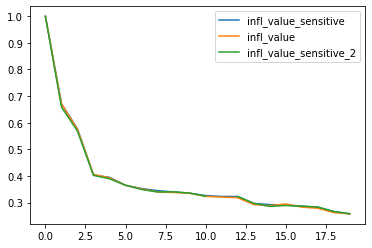

In [100]:
infl_summary_sensitive_analysis.reset_index().iloc[:20,1:].plot()

In [101]:
infl_summary_sensitive_analysis.reset_index().to_csv('infl_summary_sensitive_analysis_2.csv')

In [ ]:
###################################分析传染程度（contagious_value）的敏感性#####################################33

In [102]:
#对边遍历，将差值绝对值向量求和
character_error = np.array([0]*11)
for (u,v) in DG.edges:
    character_error = character_error + np.absolute( np.array(df_art_vector.loc[u][columns_need])  \
                                                    - np.array(df_art_vector.loc[v][columns_need]) )

contagiosity_sensitive_2 = pd.DataFrame(1.5 - 10*character_error/sum(character_error)).T
contagiosity_sensitive_2.columns = columns_need
contagiosity_sensitive_2.index = ['characteristic_contagiosity_sensitive_2']

In [103]:
####找回来我们之前算的contagiosity 
contagiosity = pd.read_csv('characteristic_contagiosity.csv',header=0,index_col=0)

In [104]:
contagiosity_sensitive_2 = pd.concat([contagiosity_sensitive,contagiosity_sensitive_2])

In [105]:
contagiosity_sensitive_2

,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness
characteristic_contagiosity,0.562919,0.728570,0.478212,0.142890,0.661941,0.818704,0.292671,0.807121,0.842790,0.262149,0.902033
characteristic_contagiosity_sensitive,0.562794,0.727676,0.478951,0.144240,0.661088,0.823857,0.291083,0.807072,0.836259,0.262456,0.904524
characteristic_contagiosity_sensitive_2,0.562681,0.735059,0.477450,0.138274,0.663343,0.818840,0.281827,0.819526,0.834722,0.258454,0.909824


In [106]:
contagiosity_sensitive_2.T.corr()

,characteristic_contagiosity,characteristic_contagiosity_sensitive,characteristic_contagiosity_sensitive_2
characteristic_contagiosity,1.000000,0.999941,0.999782
characteristic_contagiosity_sensitive,0.999941,1.000000,0.999833
characteristic_contagiosity_sensitive_2,0.999782,0.999833,1.000000


In [108]:
contagiosity_sensitive_2.to_csv('contagiosity_sensitive_analysis_2.csv')

In [14]:
#读取artist数据：
df_art = pd.read_csv('data_by_artist.csv')
df_art.set_index(['artist_id'], inplace=True)
#将流派索引合并进来：
df_art = people_genre.join(df_art)
#将活跃年份索引合并进来：
df_art = people_year.join(df_art)
#去掉无关列：
df_art =  df_art.drop(columns = ['artist_name','duration_ms','popularity'])
df_art_grouped = df_art.groupby(by = ['genre'])

In [18]:
####单独提取Pop/Rock流派，后续再按年份分
df_art_P_R = df_art_grouped.get_group('Pop/Rock').drop(columns = ['genre'])

In [19]:
df_art_P_R_grouped = df_art_P_R.groupby(by = ['active_start'])

In [20]:
df_art_P_R.head()

,active_start,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness,count
759491,1980,0.361714,0.859571,0.419286,135.678000,-7.351286,1.0,7.0,0.036975,0.004043,0.248743,0.152171,14.0
74,1980,0.578000,0.865000,0.487000,117.114000,-7.062000,1.0,9.0,0.026400,0.001850,0.365000,0.046000,2.0
335,1990,0.540515,0.494879,0.491576,126.211818,-12.460424,1.0,0.0,0.187772,0.143038,0.142439,0.037918,33.0
66915,1960,0.512598,0.477932,0.551934,126.160149,-11.184330,1.0,7.0,0.562567,0.034211,0.308978,0.064535,1092.0
71209,1950,0.502849,0.252807,0.338918,116.601288,-15.844986,1.0,9.0,0.729745,0.027331,0.149112,0.038779,146.0


In [22]:
df_art_P_R['active_start'].value_counts()

1990    664
1980    612
2000    480
1970    419
1960    410
2010    116
1950    103
1940      2
1930      1
Name: active_start, dtype: int64

In [23]:
#计算按年份，pop/rock流派的音乐特点变化，得到相应的字典
df_art_P_R_year = {}
for year in active_start_list:
    P_R_year = df_art_P_R_grouped.get_group(year)
    year_vector = []
    for column in columns_need:
        mean = (P_R_year[column] * P_R_year['count']).sum()/P_R_year['count'].sum()
        year_vector.append(mean)
    df_art_P_R_year[year] = year_vector
df_art_P_R_year = pd.DataFrame(df_art_P_R_year)

In [24]:
#得到各个年份的音乐特点向量dataframe
df_art_P_R_year = df_art_P_R_year.T
df_art_P_R_year.columns = ['danceability','energy','valence','tempo','loudness','mode', \
                       'key','acousticness','instrumentalness','liveness','speechiness']

In [25]:
df_art_P_R_year.head()

,danceability,energy,valence,tempo,loudness,mode,key,acousticness,instrumentalness,liveness,speechiness
1930,0.464500,0.545500,0.541167,114.825000,-9.204667,1.000000,4.000000,0.709667,0.000000,0.256500,0.041367
1940,0.627392,0.551280,0.690458,113.079308,-11.794342,1.000000,0.833333,0.527493,0.019084,0.175693,0.053243
1950,0.524107,0.496558,0.619201,117.689167,-11.676612,0.998351,4.643809,0.549034,0.089818,0.220886,0.056108
1960,0.501910,0.562945,0.563900,121.524779,-10.865514,0.982033,4.976991,0.345754,0.090398,0.236861,0.051637
1970,0.512119,0.661882,0.562141,125.499456,-9.824307,0.952496,5.271991,0.214210,0.100306,0.223797,0.056676


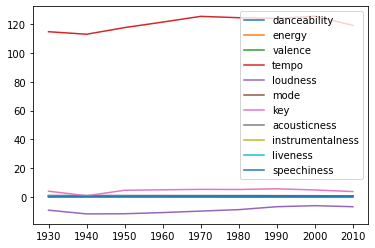

In [26]:
df_art_P_R_year.plot()

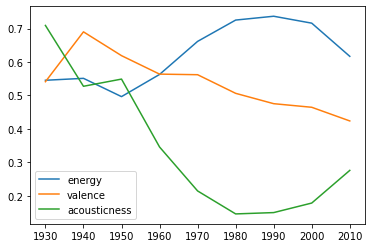

In [109]:
df_art_P_R_year.drop(columns = ['tempo','key','loudness','mode','danceability','instrumentalness','liveness','speechiness']).plot()

In [30]:
df_art_P_R_year.to_csv('6 df_art_P_R_year.csv')

In [110]:
import fffff

ModuleNotFoundError: No module named 'fffff'

In [ ]:
############################################    网络构建   ############################################
import networkx as nx
import pandas as pd
import numpy as np

#导入influence数据集
df_infl = pd.read_csv('influence_data.csv',encoding = 'utf8')

#删除艺术家名字的列，因为我们只用id来代表艺术家
df_infl = df_infl.drop(columns = ['influencer_name','follower_name'])

#构造图：
DG = nx.DiGraph()
for index,row in df_infl.iterrows():
    #连出来有向边：
    DG.add_edges_from([(row['influencer_id'], row['follower_id'])])
    #为节点赋‘genre’属性
    DG.nodes[row['influencer_id']]['genre'] = row['influencer_main_genre']
    DG.nodes[row['follower_id']]['genre'] = row['follower_main_genre']
    #为节点赋‘active_start’属性
    DG.nodes[row['influencer_id']]['active_start'] = row['influencer_active_start']
    DG.nodes[row['follower_id']]['active_start'] = row['follower_active_start']

###########去掉空行傻逼节点：477787 （其余信息都空）
DG.remove_node(477787)

In [ ]:
#########################主成分分析，试图对音乐的维度降维#######################
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
#导入数据集：
df_music = pd.read_csv('full_music_data.csv')

#去掉不进行主成分分析的列
df_music = df_music.drop(columns = ['artist_names','artists_id','duration_ms','popularity','year','release_date','song_title (censored)'])

#标准化
data = scale(df_music.values)
#PCA
pca = PCA(n_components = 12) 
pca.fit(data)
var = pca.explained_variance_ratio_ 
#输出解释方差比：
var

In [ ]:
#################### KNN #######################
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
#读取artist数据：
df_art = pd.read_csv('data_by_artist.csv')

#####标准化#####
import math
#定义一个函数，将某一列按照count进行加权标准化,输入数据集，想要标准化的列column，以及权重列weight（str格式）
def standard(df, column, weight):
    mean = (df[column] * df[weight]).sum()/df[weight].sum()
    std = math.sqrt( ((df[column] - mean)**2  * df[weight]).sum()/df[weight].sum() )
    df[column] = (df[column]-mean)/std

columns_need = ['danceability','energy','valence','tempo','loudness','mode','key','acousticness','instrumentalness','liveness','speechiness']
for column in columns_need:
    standard(df_art,column,'count')

df_art.set_index(['artist_id'], inplace=True)

#制作艺术家和流派的索引集：
people_genre = {}
for node in DG.nodes:
    people_genre[node] = DG.nodes[node]['genre']

people_genre = pd.DataFrame.from_dict(people_genre,orient='index')
people_genre.columns = ['genre']

#调整列数
df_art_vector =  df_art.drop(columns = ['artist_name','duration_ms','popularity'])
df_art_vector = people_genre.join(df_art_vector)

df = df_art_vector
#分开features和class：
x_data = df.drop(['genre','count'],axis=1)
y_data = df['genre']
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(x_data)
data = pd.DataFrame(X_data_minmax,columns=['danceability', 'energy', 'valence', 'tempo', 'loudness',
       'mode', 'key','acousticness', 'instrumentalness', 'liveness',
       'speechiness'])


# 这里采用后边调参得到的最优参数:13,1,1
X_train, X_test, y_train, y_test = train_test_split(data, y_data,test_size=0.1, random_state = 1)
knn_clf=KNeighborsClassifier(n_neighbors = 13 , weights = 'distance',algorithm = 'brute', p = 1)
knn_clf.fit(X_train,y_train)
ypred=knn_clf.predict(X_test) #These are the predicted output values

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
result = confusion_matrix(y_test, ypred)
print('Confusion Matrix:')
print(result)
result2 = accuracy_score(y_test,ypred)
print('Accuracy:',result2)

In [ ]:
###########################调参####################
def para(size,n,p):
    X_train, X_test, y_train, y_test = train_test_split(data, y_data,test_size = size , random_state = 1)
    knn_clf=KNeighborsClassifier(n_neighbors = n , weights = 'distance',algorithm = 'kd_tree' , p = p)
    knn_clf.fit(X_train,y_train)
    ypred=knn_clf.predict(X_test) 
    result2 = accuracy_score(y_test,ypred)
    return result2

for size in range(1,4):
    for n in range(4,16):
        for p in range(1,4):
            print([size,n,p],t)